In [1]:
!pip install pennylane-lightning[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.3 MB/s eta 0:00:00


In [2]:
import pennylane as qml
import pennylane.numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Load and preprocess data
data = load_breast_cancer()
X = data.data[:, :25]
y = data.target


In [3]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = normalize(scaler.fit_transform(X_train), norm='l2')
X_test = normalize(scaler.transform(X_test), norm='l2')

STANDARD_DEVIATION = 0.1
IS_AUG = 0 # Set to 0 to disable augmentation

if IS_AUG == 1:
    print("Augmenting data...")
    # Create the augmented data by adding noise
    X_train_aug = X_train + np.random.normal(0, STANDARD_DEVIATION, X_train.shape)

    # Combine the original and augmented data
    X_train = np.vstack([X_train, X_train_aug])
    y_train = np.hstack([y_train, y_train])
else:
    print("Skipping augmentation.")


Skipping augmentation.


In [4]:

def pca(X, num_components=5):
    rho = sum(np.outer(x, x) for x in X) / len(X)
    eigvals, eigvecs = np.linalg.eigh(rho)
    top_indices = np.argsort(eigvals)[-num_components:]
    top_vectors = eigvecs[:, top_indices]
    return X @ top_vectors

X_train = pca(X_train, 5)
X_test = pca(X_test, 5)



In [5]:
dev = qml.device("lightning.gpu", wires=5)

def variational_block(x, weights):
    for i in range(5):
        qml.RY(x[i], wires=i)
        qml.RZ(x[i] ** 2, wires=i)
    for i in range(5):
        qml.RY(weights[i], wires=i)
    for i in range(4):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[4, 0])

@qml.qnode(dev)
def quantum_node(x, weights):
    variational_block(x, weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def hybrid_model(x, params):
    q_out = np.array(quantum_node(x, params[:5]), requires_grad=True)
    hidden = leaky_relu(np.dot(params[5:10], q_out) + params[10])
    output = leaky_relu(np.dot(params[11:16], hidden) + params[16])
    final = sigmoid(np.dot(params[17:22], output) + params[22])
    return final

def weighted_bce(preds, labels, pos_weight):
    return -np.mean(pos_weight * labels * np.log(preds + 1e-6) +
                    (1 - labels) * np.log(1 - preds + 1e-6))

class_weights = np.array([1.0, len(y_train) / (2 * np.bincount(y_train)[1])])

def cost(params, X, y):
    preds = np.array([hybrid_model(x, params) for x in X], requires_grad=True)
    bce = weighted_bce(preds, y, pos_weight=class_weights[1])
    reg = 0.001 * np.sum(params ** 2)
    return bce + reg

def compute_metrics(params, X, y):
    preds = [hybrid_model(x, params) > 0.5 for x in X]
    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds, zero_division=0)
    rec = recall_score(y, preds, zero_division=0)
    f1 = f1_score(y, preds, zero_division=0)
    return acc, prec, rec, f1



In [6]:
np.random.seed(42)
params = np.random.uniform(-0.1, 0.1, 23, requires_grad=True)
opt = qml.AdamOptimizer(0.01)
epochs = 100

train_losses = []
test_losses = []
train_accs = []
test_accs = []
best_acc = 0
best_epo = 0
best_param = []
for epoch in range(epochs):
    params = opt.step(lambda p: cost(p, X_train, y_train), params)

    train_loss = cost(params, X_train, y_train)
    test_loss = cost(params, X_test, y_test)

    # Compute metrics for train and test sets
    train_acc, train_prec, train_rec, train_f1 = compute_metrics(params, X_train, y_train)
    test_acc, test_prec, test_rec, test_f1 = compute_metrics(params, X_test, y_test)

    # Store metrics
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Track best test accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        best_epo = epoch
        best_params = params.copy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {train_loss:.4f}")
        print(f"Train - Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}")
        print(f"Test  - Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}")



Epoch 0 | Loss: 0.6077
Train - Acc: 0.3736, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
Test  - Acc: 0.3684, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
Epoch 10 | Loss: 0.6018
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 20 | Loss: 0.5975
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 30 | Loss: 0.5968
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 40 | Loss: 0.5956
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 50 | Loss: 0.5876
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 60 | Loss: 0.5486
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 7

In [7]:
# Final evaluation with best parameters
print("\nFinal Results with Best Parameters (Epoch {}):".format(best_epo))
train_acc, train_prec, train_rec, train_f1 = compute_metrics(best_params, X_train, y_train)
test_acc, test_prec, test_rec, test_f1 = compute_metrics(best_params, X_test, y_test)
print(f"Train - Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}")
print(f"Test  - Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}")


Final Results with Best Parameters (Epoch 91):
Train - Acc: 0.9451, Prec: 0.9194, Rec: 1.0000, F1: 0.9580
Test  - Acc: 0.9649, Prec: 0.9474, Rec: 1.0000, F1: 0.9730


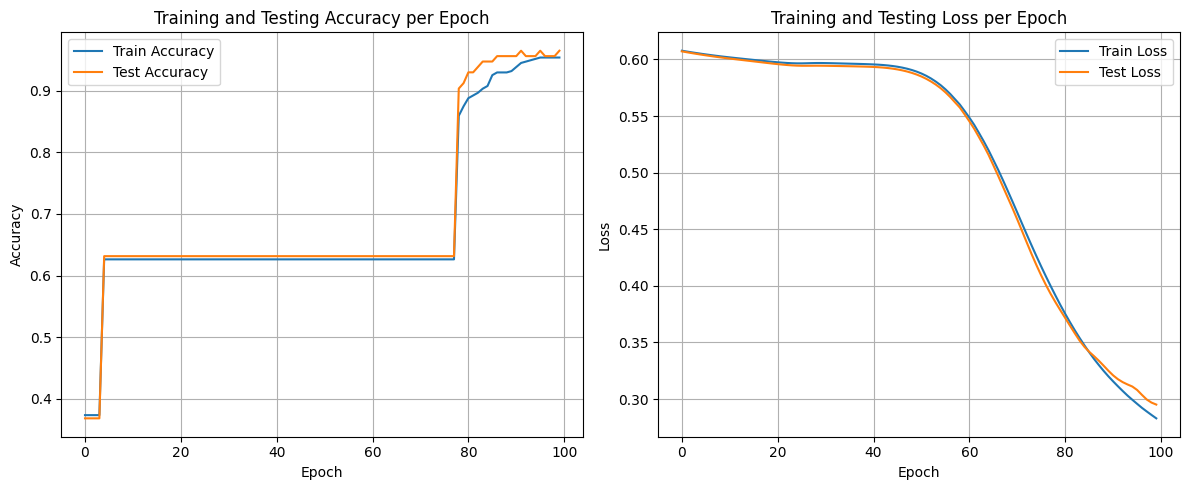

In [8]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accs, label='Train Accuracy')
plt.plot(range(epochs), test_accs, label='Test Accuracy')
plt.title('Training and Testing Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.title('Training and Testing Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics_no_aug.png')
